In [1]:
%pylab inline
import pandas as pd
from matplotlib.path import Path
from matplotlib.patches import PathPatch

def rand_jitter(data, stdev):
    return data + np.random.randn(len(data)) * stdev

def half_and_half_plot(data, x, y, plot_type='violin', 
                       markersize = 15, jitter=0.1, 
                       width=0.5, ax=None, **kwargs):
    """
    Parameters
    ----------
    data : pd.Dataframe
           Dataframe
    x : str
        Column of dataframe to use as xaxis
    y : str
        Column of dataframe to use as yaxis
    plot_type : str
                Plot violin or box
    width : float
            Width of box or violin plot    
    marker_size : int
                  Size of markers  
    jitter : float
             Used only when plot_type=violin
    ax : matplotlib.Axes
         Axis object to use for plotting
             
    """
    
    data_grouped = data.groupby(x)
    keys = data_grouped.groups.keys()
    values = [data_grouped.get_group(key).sepal_length.tolist() for key in keys]
    if ax is None:
        f, ax = plt.subplots(figsize=(15,8))
    
    key_colors = []
    if plot_type == 'violin':
        dist_plot = ax.violinplot(values, 
                                  widths=width,
                                  points=kwargs.get('points', 200), 
                                  showmeans=kwargs.get('showmeans', False),
                                  showextrema=kwargs.get('showextrema', False), 
                                  showmedians=kwargs.get('showmedians', False))
        boundaries = dist_plot['bodies']
        for bindex, b in enumerate(boundaries):
                m = np.mean(b.get_paths()[0].vertices[:, 0])
                b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], -np.inf, m)
                value = np.array(values[bindex])
                y_path = b.get_paths()[0].vertices[:, 1]
                x_path = b.get_paths()[0].vertices[:, 0]
                xindex = np.array([0.985] * len(value))
                marked = []
                for v in value:
                    yindex = np.argmin(np.abs(y_path-v))
                    # fetch points from this yindex, less than or equidistant than our original point
                    yval = y_path[yindex]
                    min_dist = np.abs(yval-v)
                    distances = np.abs(value-yval)
                    dist_lesser_or_equ = np.where(distances <= min_dist)
                    dist_lesser_or_equ = dist_lesser_or_equ[0]
                    n_points = len(dist_lesser_or_equ)
                    total_width = x_path[yindex]-1-bindex
                    distance_per_point = total_width/float(n_points)
                    for index, i in enumerate(dist_lesser_or_equ):
                        if i not in marked:
                            xindex[i] = xindex[i] + index*distance_per_point
                            marked.append(i)

                p = ax.scatter(2+bindex-xindex, value, s=markersize)
                b.set_color(p.get_facecolor()[0])
        ax.set_xticks(range(1, len(keys)+1))
        ax.set_xticklabels(keys)
        ax.set_xlabel(x)
        ax.set_ylabel(y)
    elif plot_type == 'box':
        if 'notch' in kwargs.keys():
            raise NotImplementedError('notch not implemented yet.')
        dist_plot = ax.boxplot(values,
                               widths=width,
                               showmeans=kwargs.get('showmeans', False),
                               showfliers=kwargs.get('showfliers', False))        
        boundaries = dist_plot['boxes']
        stdev = jitter * width
        for bindex, b in enumerate(dist_plot['boxes']):
            value = np.array(values[bindex])
            y_path = b.get_path().vertices[:, 1]
            x_path = b.get_path().vertices[:, 0]
            xindex = np.array([1+width/3.0] * len(value))
            xindex = rand_jitter(xindex, stdev)
            p = ax.scatter(xindex+bindex, value, s=markersize)
            b.set_color(p.get_facecolor()[0])
            xmid = (b.get_path().vertices[0,0] + b.get_path().vertices[1,0])/2.0
            ymid = b.get_path().vertices[0,1]
            xbotleft =  b.get_path().vertices[-1,0]
            ytopleft =  b.get_path().vertices[-2,1]

            lpath = Path(np.array([[xmid, ymid], [xbotleft, ymid], [xbotleft, ytopleft], [xmid, ytopleft]]))

            patch = PathPatch(lpath, edgecolor=p.get_facecolor()[0], facecolor='white')    
            b.remove()
            ax.add_patch(patch)
            key_colors.append(p.get_facecolor()[0])
        ax.set_xticks(range(1, len(keys)+1))
        ax.set_xticklabels(keys)
        ax.set_xlabel(x)
        ax.set_ylabel(y)
        if not dist_plot['medians']:
            return ax
            
        for bindex, b in enumerate(dist_plot['medians']):
            xmid = (b.get_path().vertices[0,0] + b.get_path().vertices[1,0])/2.0
            ymid = b.get_path().vertices[0,1]
            xleft = b.get_path().vertices[0,0]
            lpath = Path(np.array([[xmid, ymid], [xleft, ymid]]))
            patch = PathPatch(lpath, edgecolor=key_colors[bindex], facecolor='white')
            b.remove()
            ax.add_patch(patch)
    else:
        raise NotImplementedError('{} not implemented'.format(plot_type))
            
    return ax

Populating the interactive namespace from numpy and matplotlib


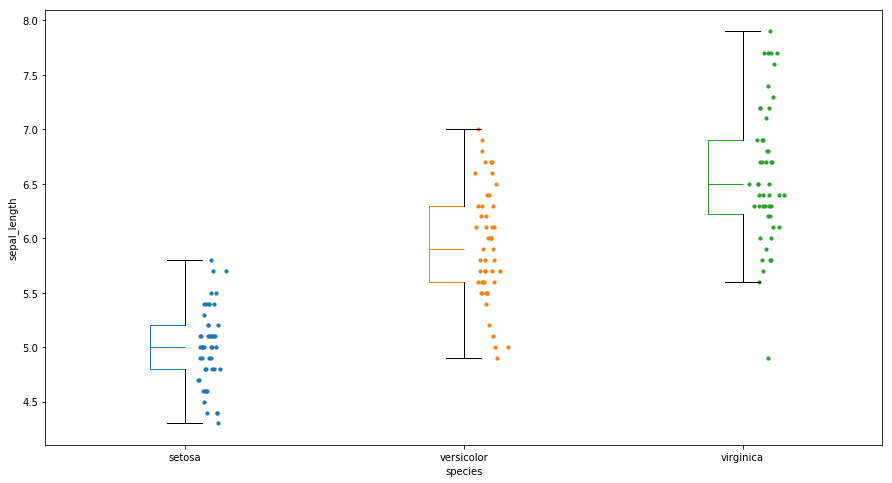

In [2]:
iris = pd.read_csv('data/iris.csv')
half_and_half_plot(iris, 'species', 'sepal_length', 'box', width=0.25, markersize=10)

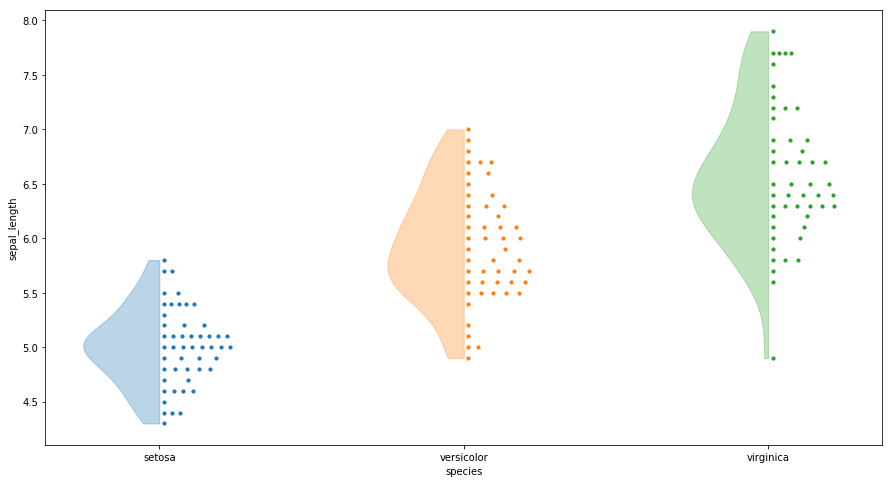

In [3]:
half_and_half_plot(iris, 'species', 'sepal_length', 'violin', markersize=10)

Originally came from this tweet: https://twitter.com/helenajambor/status/965929984366927872

R (and way simpler!) implementation: https://gist.github.com/jbburant/b3bd4961f3f5b03aeb542ed33a8fe062